In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from HeatEquation_DeepHPM import HeatEquationHPMNet, load_checkpoint, getDefaults, loadTimesteps
from UKDDataset import HeatEquationHPMDataset, SchrodingerEquationDataset

In [2]:
#pathModel = 'results/models/UKD_DeepHPM/0_ic/model_2900.pt'
#pathModel = 'results/models/UKD_HPM_2ndNorm_rand/0_ic/model_3300.pt'
pathModel = 'results/models/UKD_HPM_2ndNorm_HPM/1_pde/model_1900.pt'
pathData = '../../data/UKD/2014_022_rest.mat'

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(pData=pathData, maxFrames = 500)
coordinateSystem = getDefaults(args)

500 frames <-> tmax: 9.6 seconds


The following code initializes our models and loads a pretrained model from `pathModel`. 

In [3]:
lb = np.array([coordinateSystem["x_lb"], coordinateSystem["y_lb"], 0.])
ub = np.array([coordinateSystem["x_ub"], coordinateSystem["y_ub"], coordinateSystem["tmax"]])

maxFrames = 500
nx = 640
ny = 480
nt = maxFrames
numFeatures = 500
numLayers = 8
numLayers_hpm = 8
numFeatures_hpm = 300


model = HeatEquationHPMNet(numLayers, numFeatures, numLayers_hpm, numFeatures_hpm, lb, ub,
                          5, 5, torch.tanh).cuda()

In [4]:
load_checkpoint(model, pathModel)

Let's create a dataset object amd check the output of the neural network on a certain slice (index) of that 

In [10]:
numBatches = 500
batchSize = 307200
ds = HeatEquationHPMDataset(pathData, coordinateSystem, batchSize, maxFrames=maxFrames, shuffle=False, useGPU=False)

Eu shape (499, 307200)
batchSize: 307200
self.numSamples: 153292800
numBatches: 499


In [11]:
train_loader = torch.utils.data.DataLoader(ds, batch_size=1)

and evaluate the dataset on every time step of the simulation

In [12]:
import time

st = time.time()
Es = np.zeros( (nx*ny,nt) )
i = 0
for x, y, t, Ex_u in train_loader:
    inputX = torch.stack([x.squeeze(), y.squeeze(), t.squeeze()], 1).float().cuda()
    with torch.no_grad():
        Ex_u_pred = model.forward(inputX).view(-1).cpu().numpy()
    Es[:,i] = Ex_u_pred.reshape(-1)
    i = i+1
    
et = time.time() - st

Load ground-truth temperatures from file:

In [ ]:
u, timing = ds.loadFrame(pathData)

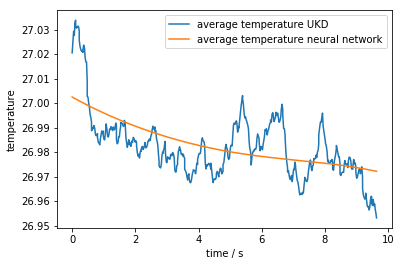

In [9]:
plt.plot(timing[0:nt], np.mean(u[0:nt,:],1), timing[0:nt], np.mean(Es,0))
plt.legend(['average temperature UKD', 'average temperature neural network'])
plt.xlabel('time / s')
plt.ylabel('temperature')
plt.show()

In [ ]:
plt.plot(timing[0:nt], np.mean(u[0:nt,:],1), timing[0:nt], np.mean(Es,0))
plt.legend(['average temperature UKD', 'average temperature neural network'])
plt.xlabel('time / s')
plt.ylabel('temperature')
plt.show()

In [15]:
Es_r = Es.reshape((640,480,500))
u_r = u[0:nt,:].transpose().reshape((640,480,500))

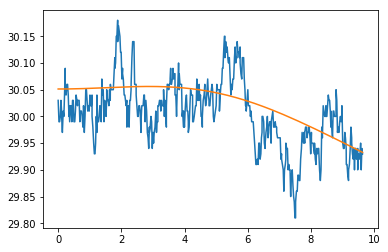

In [16]:
plt.plot(timing[0:nt], u_r[320,240,:], timing[0:nt], Es_r[320,240,:])

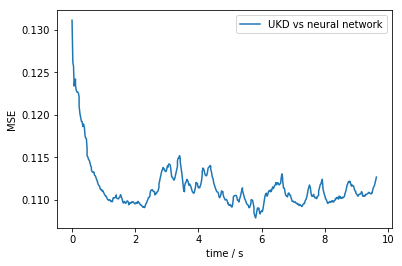

In [91]:
plt.plot(timing[0:nt], np.mean(  abs(Es - u[0:nt,:].transpose()),axis=0))
plt.legend(['UKD vs neural network'])
plt.xlabel('time / s')
plt.ylabel('MSE')
plt.show()

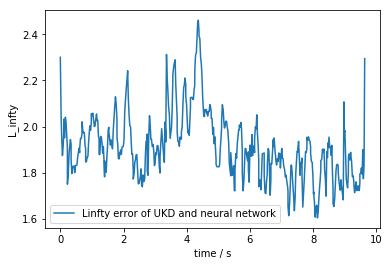

In [92]:
plt.plot(timing[0:nt], np.max(  abs(Es - u[0:nt,:].transpose()),axis=0))
plt.legend(['Linfty error of UKD and neural network'])
plt.xlabel('time / s')
plt.ylabel('L_infty')
plt.show()

Visualize some slice (499) of the training set

In [29]:
x, y, t, Ex_u = ds.__getitem__(0)

inputX = torch.stack([x, y, t], 1)
Ex_u_pred = model.forward(inputX.cuda()).view(-1)
Ex_u_pred = Ex_u_pred.cpu().detach().numpy().reshape(640,480)

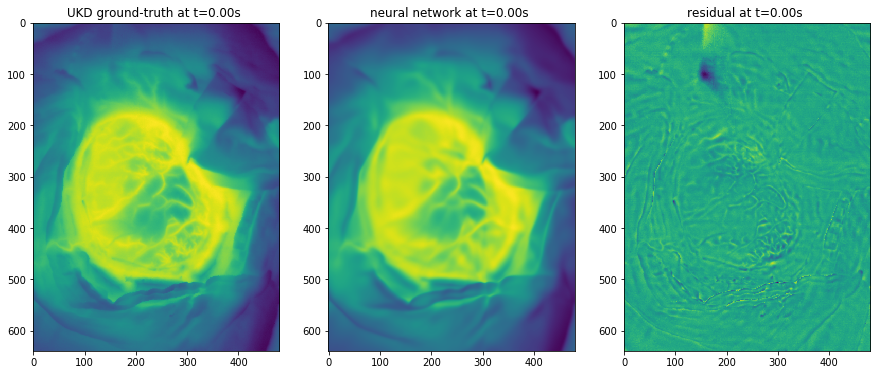

In [30]:
f, axarr = plt.subplots(1, 3, figsize=(15, 10))
cm = ['RdBu_r', 'viridis']

pcm = axarr[0].imshow(Ex_u.reshape(640,480))
axarr[0].set_title('UKD ground-truth at t=%.2fs ' % (t[0]))

pcm = axarr[1].imshow(Ex_u_pred)
axarr[1].set_title('neural network at t=%.2fs ' % (t[0]))

pcm = axarr[2].imshow(Ex_u.reshape(640,480) - Ex_u_pred)
axarr[2].set_title('residual at t=%.2fs ' % (t[0]))

plt.show()